In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("C:\\Users\\mahdi\\Desktop\\bridge\\noise\\analog.csv")

In [3]:
datatime = np.ravel(data[["Time [s]"]].to_numpy())
bridge_ac = np.ravel(data[["Bridge-in"]].to_numpy())
bridge_ac.shape
bridge_ac -= np.mean(bridge_ac)

In [4]:
sampling_rate = np.mean(np.ediff1d(datatime))
print(f'sampling_period={sampling_rate} s')
fs = 1 / sampling_rate
print(f'sampling rate={fs} Hz')
len(bridge_ac)

sampling_period=0.02 s
sampling rate=50.0 Hz


6005

In [5]:
# in seconds
observing_interval = (10**4, 10**6)
observing_band = (1 / observing_interval[1], 1 / observing_interval[0])
observing_interval = np.exp(np.log(observing_interval).mean())
print(observing_interval)
print(observing_band)
#sample_period = 
sample_rate = 1/10**6

100000.00000000001
(1e-06, 0.0001)


In [6]:
t0 = sampling_rate
sense = np.cumsum(bridge_ac)*t0
sense

array([ 4.62114904e-05,  9.24229808e-05,  3.86344713e-05, ...,
       -9.24229809e-05, -4.62114904e-05, -1.44412260e-15])

In [7]:
maxNumM = 100
L = len(sense)
maxM = 2**np.floor(np.log2(L/2))
maxM

2048.0

In [8]:
m = np.logspace(np.log10(1), np.log10(maxM), maxNumM)
m = np.ceil(m)
m = np.unique(m)
m.size

79

In [9]:
tau = m * t0

allanvar = np.zeros(m.size)
for i in range(m.size):
	mi = int(m[i])
	allanvar[i] = np.sum((sense[2*mi:L]- 2*sense[mi:L-mi] + sense[:L-2*mi])**2)

allanvar /= (2*tau**2 * (L-2*m))
adev = np.sqrt(allanvar)

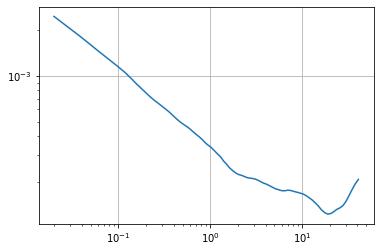

In [10]:
import matplotlib.pyplot as plt

plt.loglog(tau, adev)
plt.grid()

White noise spectrum

\begin{equation}
S_A(f) = N^2
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{N^2}{\tau}
\end{equation}

In [11]:
# find the index where the slope of the log-scaled Allan deviation is equal to the slope specified
slope = -1/2
logtau = np.log10(tau)
logadev = np.log10(adev)
dlogadev = np.diff(logadev) / np.diff(logtau)
idx = np.argmin(np.abs(dlogadev - slope))

# find the y intercept of the line
b = logadev[idx] - slope*logtau[idx]
logN = slope*np.log10(1) + b
N = 10**logN

tauN = 1
lineN = N / np.sqrt(tau)

Red noise (brownian noise) spectrum

\begin{equation}
S_A(f) = (\frac{K}{2\pi})^2\frac{1}{f^2}
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{K^2\tau}{3}
\end{equation}

In [12]:
slope = 0.5
idx = np.argmin(np.abs(dlogadev - slope))
b = logadev[idx] - slope*logtau[idx]

logK = slope*np.log10(3) + b
K = 10**logK
lineK = K * np.sqrt(tau / 3)

Bias instability due to pink noise (flickr noise) spectrum

\begin{equation}
S_A(f)=(\frac{B^2}{2\pi})\frac{1}{f}
\end{equation}

\begin{equation}
\sigma^2(\tau) = \frac{2B^2}{\pi}[ln{2} -\frac{\sin{x}^2}{2x^2}(\sin{x}+4x\cos{x})+Ci(2x)-Ci(4x)]
\end{equation}

$ Ci $ is the cosine integration function and $x = 2\pi f_0 \tau$

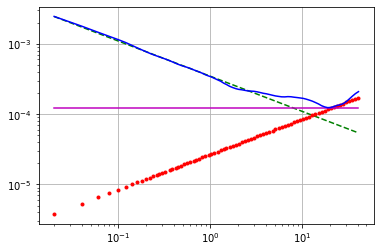

In [16]:
slope = 0.0
idx = np.argmin(np.abs(dlogadev[dlogadev.size * 3 // 4:-5] - slope))
idx += dlogadev.size * 3 // 4
b = logadev[idx] - slope*logtau[idx]

scfB = np.sqrt(2 * np.log(2) / np.pi)
logB = b - np.log10(scfB)
B = 10**logB
lineB = B * scfB * np.ones(tau.size)

plt.loglog(tau, lineN, '--', color='g')
plt.loglog(tau, lineK, '.', color='r')
plt.loglog(tau, lineB, '-', color='m')
plt.loglog(tau, adev, color='b')
plt.grid()


In [14]:
N, K, B

(0.0003453489004621177, 4.621697716225145e-05, 0.00026474617103199526)